<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/model_training_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training and hyperparameter optimization for Age-prediction
Here we use Keras and the Talos library to set up the hyperparameter optimization. 

***Warning***: since we are using colab, we need to (1) install talos (2) re-start the running environment AFTER installing Talos (to update some packages that Talos needs to un) before running the optimization.  

In [0]:
!pip install talos
!pip install rarfile

In [1]:
# Let's import Talos, Keras, and dependencies

import talos as ta
from talos.metrics.keras_metrics import precision_acc, recall_acc, matthews_correlation_acc, fmeasure_acc
from talos.model.normalizers import lr_normalizer
from talos.utils.best_model import best_model, activate_model
from talos import Predict

from keras.activations import relu, elu, sigmoid
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler 

import pandas as pd
from numpy import genfromtxt
from collections import Counter
import rarfile, csv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Data preparation
First, we need to split the data into training and testing as usual. The training dataset will be feed into the model training and optimization process The testing data will be used to evalute the model. 

In [2]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 660 (delta 3), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (660/660), 96.37 MiB | 50.68 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [3]:
# Read csv files from compressed rar file and convert into a dataframe
rar_path = rarfile.RarFile("CovNet_Human_Drawings/data/merged_dataframes_prediction/x_drawings_features_max_pool_5.rar")
csv_file_name = "x_drawings_features_max_pool_5.csv"
rar_file = rarfile.RarFile.open(rar_path, csv_file_name)
x = pd.read_csv(rar_file, sep=",", header=None)
print(x.shape)
print(x.iloc[0:5,0:5])

(258, 25088)
          0    1    2         3         4
0 -0.001317  0.0  0.0 -0.001322 -0.003181
1 -0.001052  0.0  0.0 -0.001056 -0.002540
2 -0.001176  0.0  0.0 -0.001181 -0.002840
3 -0.000836  0.0  0.0 -0.000839 -0.000957
4 -0.001163  0.0  0.0 -0.001168  0.011156


In [0]:
x = x.values # as numpy array

In [8]:
# Read labels vector
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_age_adult_labels.csv'
y = genfromtxt(y_path, delimiter=',')

#x = x.drop([0]) # drop headers
print(y.shape)
print(y[0:5])

(258,)
[0. 0. 0. 0. 0.]


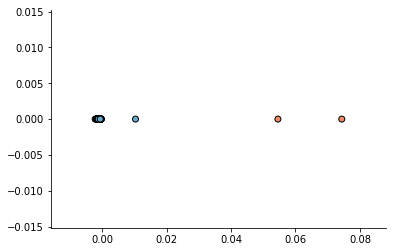

In [9]:
# Let's look at the distribution of 0s and 1s

colors = ['#ef8a62' if v == 0 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(x[:, 0], x[:, 1], c=colors, **kwarg_params)
sns.despine()

In [10]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44)
print(x_train.shape) 
print(y_train.shape) 
print(x_test.shape) 
print(y_test.shape)

(180, 25088)
(180,)
(78, 25088)
(78,)


###Resampling imbalanced data
Since our classes are imbalanced, we will use oversampling of the "adult" class **on the training set**  to help training on that class. *imblearn* implement oversampling for us

**See documentantion at** https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html

In [0]:
ros = RandomOverSampler(random_state=42)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

In [12]:
print(x_train_res.shape) # (258, 200)
print(y_train_res.shape) # (258,)
print('Resampled dataset shape %s' % Counter(y_train_res))

# Now we have 50/50 balanced classes

(286, 25088)
(286,)
Resampled dataset shape Counter({1.0: 143, 0.0: 143})


## Model Definition
Here we define the model using Keras. The main point is to pass all the arguments as keys of a Python dictionary instead of variables

In [0]:
# define model
def input_model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # add hidden layer
  model.add(Dense(params['first_neuron'], 
                  input_dim=x_train.shape[1], 
                  activation=params['activation'],
                  kernel_initializer = params['kernel_initializer']))
  # add dropout layer
  model.add(Dropout(params['dropout']))
  # add output layer
  model.add(Dense(1,activation=params['last_activation'],
                  kernel_initializer = params['kernel_initializer']))
  # compile model
  model.compile(loss=params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                metrics=['acc', fmeasure_acc, recall_acc, precision_acc, matthews_correlation_acc])
  # train model
  out = model.fit(x_train, y_train,
                  validation_data=[x_val, y_val],
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose = 0)
  return out, model

## Setting the Parameter Space Boundaries 
here we create a dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

In [0]:
# set hyperparameters to optimize
p = {'first_neuron': [4, 8, 16, 32, 64],
     'activation': [relu, sigmoid],
     'optimizer': [Nadam, Adam],
     'losses':[binary_crossentropy],
     'hidden_layers':[0, 1, 2],
     'batch_size': [10, 20, 40],
     'epochs':[10, 100, 200],
     'dropout': [0, 0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'lr':[0.01, 0.1, 0.2],
     'last_activation': ['sigmoid']}

## Running the hyperparameter optimization with Scan() 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example.



In [15]:
# starting optimization
h = ta.Scan(x= x_train_res, y=y_train_res,
            params=p,
            model=input_model,
            # I use .29 split because that is ~20% of all data
            val_split = 0.29,
            dataset_name='Draw_a_person',
            experiment_no='experiment_1',
            grid_downsample=.02)

  0%|          | 0/194 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


100%|██████████| 194/194 [29:58<00:00,  6.04s/it]


## Accessing the results through the Scan object
The scan object saves all the necessary information for analysis and deployment
**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/scan/Scan.py

In [16]:
# accessing the results data frame
h.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,100,0.360625,0.903614,0.914633,1.000000,0.873781,0.824478,0.076157,1.000000,1.000000,...,<function sigmoid at 0x7f463917eae8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,100,0.1,uniform,0.10,sigmoid
1,200,0.662502,0.855422,0.851771,0.931727,0.873494,0.715812,0.613322,0.995074,0.996211,...,<function relu at 0x7f463917e9d8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,200,0.1,normal,0.01,sigmoid
2,10,0.670817,0.855422,0.876959,1.000000,0.787866,0.722998,0.661827,0.916256,0.905934,...,<function sigmoid at 0x7f463917eae8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,10,0.1,uniform,0.20,sigmoid


In [0]:
# sort by criteria
# h.data.sort_values('val_acc')

In [17]:
# Best model based on training criteria "val_acc"
# see source code to use https://github.com/autonomio/talos/blob/master/talos/utils/best_model.py

criteria = 'acc'

# get best model id from the scan object based on some acc measure
model_id = best_model(h, criteria, False)
# activate best model based on model id
model = activate_model(h, model_id)
# makes probability predictions based on weights from best model
print(model.predict(x_test)[0:1,]) # print first value
# makes class predictions based on weights from best model
print(model.predict_classes(x_test)[0:9,]) # print first 10

# All in one line
# activate_model(scan_object, best_model(scan_object, 'val_acc', False)).predict(X)

[[0.53255486]]
[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]]


In [18]:
# accessing epoch entropy values for each round
h.peak_epochs_df[0:5] # print first 5 rows

,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,recall_acc,precision_acc,matthews_correlation_acc,acc_epoch,loss_epoch
1,99,40,40,14,40,40,99,99,99,99,99,97,0.002040,0.092001
2,199,79,79,199,79,79,199,194,194,194,160,171,0.001363,0.000263
3,9,7,7,9,7,7,9,8,8,0,8,8,0.004365,0.000017
4,199,82,82,199,82,82,199,187,181,188,186,168,0.000628,0.000013
5,99,91,91,99,91,91,99,93,90,94,87,93,0.001217,0.000080


In [19]:
# access the summary details
h.details

random_method                    uniform_mersenne
reduction_method                             None
reduction_interval                             50
reduction_window                               20
grid_downsample                              0.02
reduction_threshold                           0.2
reduction_metric                          val_acc
reduce_loss                                 False
experiment_name        Draw_a_person_experiment_1
complete_time                      04/19/19/18:02
x_shape                              (286, 25088)
y_shape                                    (286,)
dtype: object

In [20]:
# accessing the saved models
h.saved_models[0] # print first model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 25088], "dtype": "float32", "units": 64, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.1, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, 

In [0]:
# accessing the saved weights for models
# h.saved_weights[0] # print weights first model

## Reporting optimization
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

**See source code to dcide how to use this command** 
https://github.com/autonomio/talos/blob/daily-dev/talos/commands/reporting.py 

In [0]:
# use Scan object as input
r = ta.Reporting(h) # creates report object from scan object
#r = ta.Reporting('Draw_a_person_experiment_3.csv')

In [22]:
# access the dataframe with the results
r.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,100,0.360625,0.903614,0.914633,1.000000,0.873781,0.824478,0.076157,1.000000,1.000000,...,<function sigmoid at 0x7f463917eae8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,100,0.1,uniform,0.10,sigmoid
1,200,0.662502,0.855422,0.851771,0.931727,0.873494,0.715812,0.613322,0.995074,0.996211,...,<function relu at 0x7f463917e9d8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,200,0.1,normal,0.01,sigmoid
2,10,0.670817,0.855422,0.876959,1.000000,0.787866,0.722998,0.661827,0.916256,0.905934,...,<function sigmoid at 0x7f463917eae8>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f46391ccae8>,2,10,10,0.1,uniform,0.20,sigmoid


In [23]:
# get the number of rounds in the Scan
r.rounds()

194

In [24]:
# get the highest result ('val_acc' by default)
r.high()

0.9518072174256107

In [25]:
# get the highest result for any metric
print("F-measure accuracy:", r.high('val_fmeasure_acc'))
print("Training accuracy:", r.high('acc'))
print("Validation accuracy:", r.high('val_acc'))
print("Validation recall accuracy:", r.high('val_recall_acc'))
print("Validation precision accuracy:", r.high('val_precision_acc'))
print("Validation matthews correlation accuracy:", r.high('val_matthews_correlation_acc'))

F-measure accuracy: 0.9518071599753506
Training accuracy: 1.0
Validation accuracy: 0.9518072174256107
Validation recall accuracy: 1.0
Validation precision accuracy: 1.0
Validation matthews correlation accuracy: 0.9036144348512213


In [26]:
# get the round with the best result

print("F-measure accuracy best round:", r.rounds2high('val_fmeasure_acc'))
print("Training accuracy best round:", r.rounds2high('acc'))
print("Validation accuracy best round:", r.rounds2high('val_acc'))
print("Validation recall accuracy best round:", r.rounds2high('val_recall_acc'))
print("Validation precision accuracy best round:", r.rounds2high('val_precision_acc'))
print("Validation matthews correlation accuracy best round:", r.rounds2high('val_matthews_correlation_acc'))

F-measure accuracy best round: 117
Training accuracy best round: 0
Validation accuracy best round: 117
Validation recall accuracy best round: 0
Validation precision accuracy best round: 7
Validation matthews correlation accuracy best round: 117


In [27]:
# get correlation for hyperparameters against a metric
print("Hyperparameters and f-measure accuracy")
print(r.correlate('val_fmeasure_acc'),"\n")
print("Hyperparameters and validation loss")
print(r.correlate('val_loss'),"\n")
print("Hyperparameters and validation accuracy")
print(r.correlate('val_acc'),"\n")
print("Hyperparameters and recall accuracy")
print(r.correlate('val_recall_acc'),"\n")
print("Hyperparameters and precision accuracy")
print(r.correlate('val_precision_acc'))

Hyperparameters and f-measure accuracy
first_neuron     0.327924
hidden_layers   -0.003699
batch_size      -0.092609
epochs           0.320177
dropout         -0.003323
lr               0.257724
Name: val_fmeasure_acc, dtype: float64 

Hyperparameters and validation loss
first_neuron    -0.362076
hidden_layers    0.056660
batch_size       0.168656
epochs          -0.438552
dropout          0.078771
lr              -0.546637
Name: val_loss, dtype: float64 

Hyperparameters and validation accuracy
first_neuron     0.409164
hidden_layers   -0.037556
batch_size      -0.134662
epochs           0.417155
dropout          0.019501
lr               0.392778
Name: val_acc, dtype: float64 

Hyperparameters and recall accuracy
first_neuron     0.248213
hidden_layers    0.022887
batch_size      -0.062606
epochs           0.272499
dropout         -0.031886
lr               0.212883
Name: val_recall_acc, dtype: float64 

Hyperparameters and precision accuracy
first_neuron     0.333522
hidden_layers  

In [28]:
# access the row with the highest f-measure validation value
h_value = r.high('val_fmeasure_acc')
r.data.loc[r.data['val_fmeasure_acc'] == h_value]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,val_recall_acc,val_precision_acc,val_matthews_correlation_acc,loss,acc,fmeasure_acc,...,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
117,10,0.687988,0.951807,0.951807,0.975904,0.951807,0.903614,0.683146,1.0,1.0,...,<function relu at 0x7f463917e9d8>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f46391ccae8>,1,40,10,0.2,uniform,0.1,sigmoid


In [29]:
# get the best paramaters
r.best_params(n=3) # return the best 3 sets of params

array([[0.2, 40, 10, "<class 'keras.optimizers.Adam'>", 64, 'uniform',
        '<function relu at 0x7f463917e9d8>', 0.1,
        '<function binary_crossentropy at 0x7f46391ccae8>', 'sigmoid', 1,
        0],
       [0.1, 20, 100, "<class 'keras.optimizers.Nadam'>", 16, 'normal',
        '<function sigmoid at 0x7f463917eae8>', 0.2,
        '<function binary_crossentropy at 0x7f46391ccae8>', 'sigmoid', 2,
        1],
       [0.2, 10, 200, "<class 'keras.optimizers.Nadam'>", 4, 'normal',
        '<function sigmoid at 0x7f463917eae8>', 0.2,
        '<function binary_crossentropy at 0x7f46391ccae8>', 'sigmoid', 2,
        2]], dtype=object)

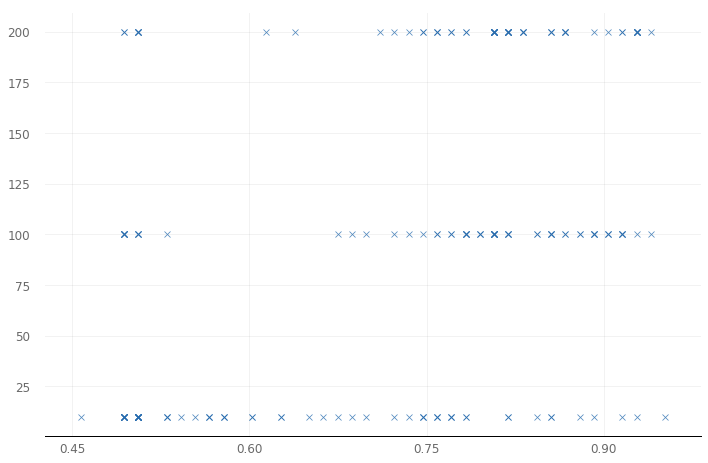

In [30]:
# a regression plot for two dimensions 
r.plot_regs("val_acc", "epochs")

None


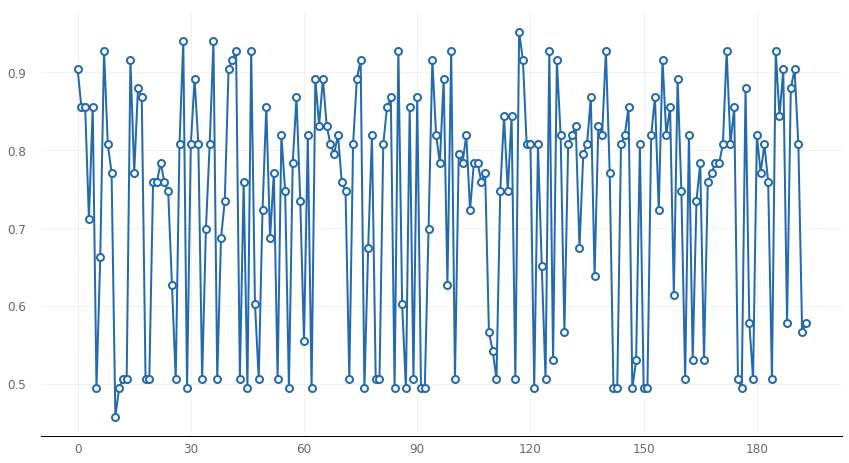

In [31]:
# line plot
print(r.plot_line("val_acc"))

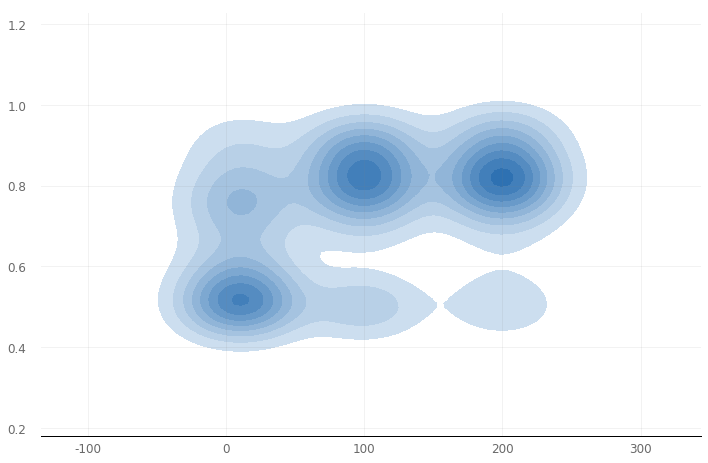

In [32]:
# up to two dimensional kernel density estimator
r.plot_kde("epochs","val_acc")

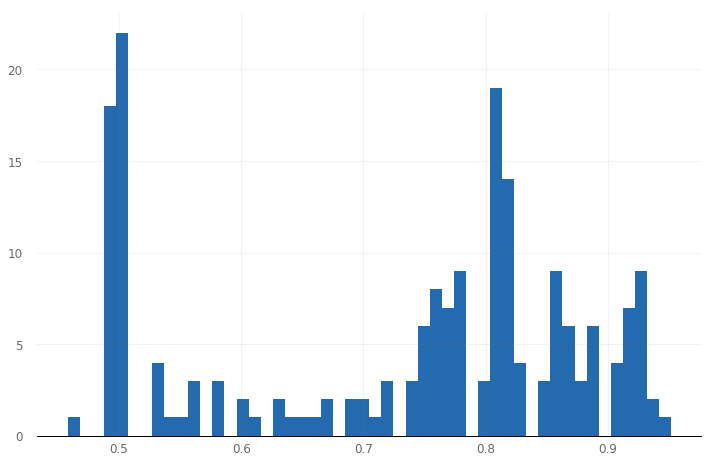

In [33]:
# a simple histogram
r.plot_hist(bins=50)

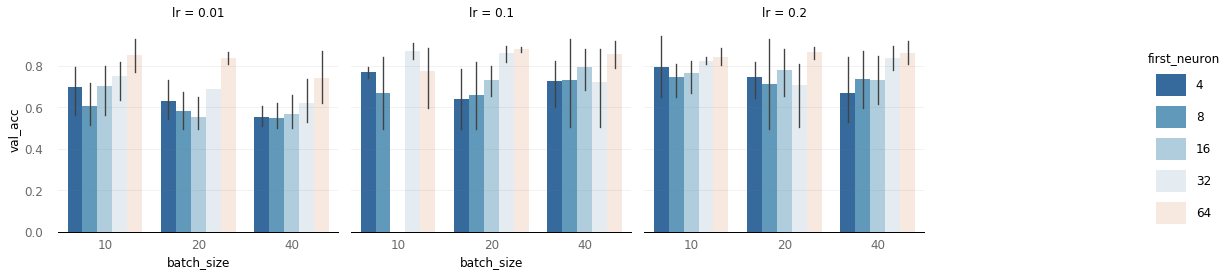

In [34]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

## Evaluating models
Models can be evaluated with Evaluate() against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the Scan process and only exposed into Evaluate once one or more candidate models have been identified.

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/evaluate.py


In [35]:
# k-fols crossvalidation with 10 folds, from test data
# we're going to validate using the f-measure or harmonic mean since 
# combines precision and recall (optimize on that)
# https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

e = ta.Evaluate(h)

e.evaluate(x=x_test, y=y_test,
           folds=10,
           shuffle=True,
           metric='val_fmeasure_acc',
           mode='binary',
           print_out=True)

mean : 0.10 
 std : 0.20


[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0]

## Evaluating model on test set

### Classification report AND Confusion matrix

Here we will iterate over all possible evaluation criteria to generate a matrix of confusion matrices. Each evaluation criteria (acc, val_acc, etc.) index the round (model) with the highest value on that criteria from all the trained models.

After model selection, we make predictions on the test set. The results for the confusion matrix and the classification report are storaged in a pandas dataframe for each model-criteria pair. 

- **accuracy:** true positives + true negatives/ total results OR OR *“for all instances, what percent was correct?”*
- **precision:** true positives / false positives + true positives OR *“for all instances classified positive, what percent was correct?”*
- **recall:** true positives / true positives + false negatives   OR  “for all instances that were actually positive, what percent was classified correctly?”
- **f1-score:** 2 * (precision * recall)/(precision + recall) // The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 
-  **support:** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing

**See documentation at** https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

In [0]:
# Here we loop over the best models based on relevant criterias to build a 
# confusion matrix and classification report 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score

import pandas as pd

# for all (child and adult)
true_neg_l = []
false_pos_l = []
false_neg_l = []
true_pos_l = []
matthews_l = []
ave_precision_l = []
accuracy_score_l = []


# for child
precision_l_c = []
recall_l_c = []
fscore_l_c = []
support_l_c = []

# for adult
precision_l_a = []
recall_l_a = []
fscore_l_a = []
support_l_a = []


criteria_list= ['acc', 'fmeasure_acc', 'recall_acc', 'precision_acc', 'matthews_correlation_acc',
               'val_acc', 'val_fmeasure_acc', 'val_recall_acc', 'val_precision_acc', 'val_matthews_correlation_acc']
for criteria in criteria_list:
  # get best model id from the scan object based on some acc measure
  model_id = best_model(h, criteria, False)
  # activate best model based on model id
  model = activate_model(h, model_id)
  
  # predicted labels
  y_pred = model.predict_classes(x_test) 
  # true labels
  y_true = y_test 
  
  # Extract confusion matrix values
  true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
  true_neg_l.append(true_neg)
  false_pos_l.append(false_pos)
  false_neg_l.append(false_neg)
  true_pos_l.append(true_pos)
  
  # extract 
  precision,recall,fscore,support = score(y_true,y_pred,average=None)
  matthews = matthews_corrcoef(y_true, y_pred)  
  ave_precision = average_precision_score(y_true, y_pred)
  acc = accuracy_score(y_true, y_pred)
  
  # child data 
  precision_l_c.append(precision[0])
  recall_l_c.append(recall[0])
  fscore_l_c.append(fscore[0])
  support_l_c.append(support[0])
  
  # adult data
  precision_l_a.append(precision[1])
  recall_l_a.append(recall[1])
  fscore_l_a.append(fscore[1])
  support_l_a.append(support[1])
  
  # matthews-score, ave-precision, total accuracy
  matthews_l.append(matthews)
  ave_precision_l.append(ave_precision)
  accuracy_score_l.append(acc)

labels = ["True_Negatives", "False_Positives", "False_Negatives", "True_Positives",
          "Precision_(Child)", "Recall_(Child)", "F-Score_(Child)","Support_(Child)",
          "Precision_(Adult)", "Recall_(Adult)", "F-Score_(Adult)","Support_(adult)",
          "Matthews_Score", "Average_Precision", "Accuracy_Score"]

data = list(zip(true_neg_l, false_pos_l, false_neg_l, true_pos_l, 
                precision_l_c, recall_l_c, fscore_l_c, support_l_c, 
                precision_l_a, recall_l_a, fscore_l_a, support_l_a, 
                matthews_l, ave_precision_l, accuracy_score_l))

assert len(criteria_list) == len(data), "criteria list and data don't match"

classification_report = pd.DataFrame(data, columns=labels, index =criteria_list )


In [37]:
# Now we can look the report in one place
classification_report 
# We can pick the one with the best numbers based on any criteria to deploy

,True_Negatives,False_Positives,False_Negatives,True_Positives,Precision_(Child),Recall_(Child),F-Score_(Child),Support_(Child),Precision_(Adult),Recall_(Adult),F-Score_(Adult),Support_(adult),Matthews_Score,Average_Precision,Accuracy_Score
acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
fmeasure_acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
recall_acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
precision_acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
matthews_correlation_acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
val_acc,60,5,11,2,0.845070,0.923077,0.882353,65,0.285714,0.153846,0.200000,13,0.100301,0.184982,0.794872
val_fmeasure_acc,60,5,11,2,0.845070,0.923077,0.882353,65,0.285714,0.153846,0.200000,13,0.100301,0.184982,0.794872
val_recall_acc,50,15,8,5,0.862069,0.769231,0.813008,65,0.250000,0.384615,0.303030,13,0.131306,0.198718,0.705128
val_precision_acc,47,18,6,7,0.886792,0.723077,0.796610,65,0.280000,0.538462,0.368421,13,0.208860,0.227692,0.692308
val_matthews_correlation_acc,60,5,11,2,0.845070,0.923077,0.882353,65,0.285714,0.153846,0.200000,13,0.100301,0.184982,0.794872


In [0]:
# save the model on a csv file
exp_n = '1'
file_name = 'classification_report_dap_' + exp_n + '.csv'
classification_report.to_csv(file_name, sep=',')

## Deploying models

Once the right model or models have been found, you can create a deployment package with Deploy() which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of:

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/deploy.py

In [40]:
# By default selects the model with best validation accuracy "recall_acc"
# Other metrics can be specified
# name code: "[dataset]-[experiment-number]-[rounds/models]-[seleccion-criteria]-[%-searched]"
rounds = str(r.rounds())
exp_n = '1'
metric = 'val_precision_acc'
proportion = '2_out_of_a_100'
filename = 'dap' + 'exp' + exp_n + metric + rounds + proportion
ta.Deploy(h, filename, metric='val_precision_acc');

Deploy package dapexp1val_precision_acc1942_out_of_a_100 have been saved.


## Restoring models
Restores the scan_object that had been stored locally as a result of talos.Deploy

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/restore.py 

In [0]:
# Restore model from local environment
model_name = # COPY NAME TO RESTOR FROM FILES
drawings = ta.Restore(model_name)

In [0]:
# make predictions with the model
drawings.model.predict(x_test)[0:9,] # print first 10

In [0]:
# get the meta-data for the experiment/optimization
print(drawings.details)

In [0]:
# get the hyperparameter space boundary for the experiment/optimization
print(drawings.params)

In [0]:
# sample of x and y data, returns pandas dataframe
print(drawings.x.iloc[0:3, 0:3]) # print first 3 rows and columns
print(drawings.y.iloc[0:3]) # print first 3 rows 

In [0]:
# the results dataframe
drawings.results[0:3] # print first 3 rows

# Resources
- **Talos repo**: https://github.com/autonomio/talos
- **Talos example**:  https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb